# Interactive tool for analyzing trained models on the ePodium dataset

1. [Input Data](#1ma)
2. [Deep Learning Model](#2ma)
3. [Make predictions on test-set](#3ma)

#### Import Packages
Note: This notebook may output tensorflow errors if cuda is not properly installed. The notebook still functions with these errors.

In [1]:
import mne
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
import ipywidgets
import tensorflow as tf
import pandas as pd

from functions.epodium import Epodium
from functions.ddp import DDP
from functions.train_and_predict import EpodiumSequence, DDPSequence
from functions import epodium, display_helper
from models.dnn import fully_connected_model
from models.hfawaz import cnn, encoder

import local_paths

2022-10-27 20:41:17.418061: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-27 20:41:17.418102: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


<br>

<a id="1ma"></a>
## 1. Input Data 

####  Choose which processed data to use
Choose from the different processed _experiment_event.npy_ files. If the _local_path.split_ folder is empty, process the raw ePodium files in the _epodium_processing_ notebook.

In [2]:
# Choose between datasets: "epodium" "ddp"
dataset_name = "ddp"

if dataset_name == "epodium":
    dataset = Epodium()    
    epochs_directory = local_paths.ePod_epochs
    event_directory = local_paths.ePod_epochs_events
    
    epod_labels = dataset.create_labels(local_paths.ePod_metadata)
    print(f"The available labels are:\n {list(epod_labels.columns)}")

elif dataset_name == "ddp":
    dataset = DDP()
    epochs_directory = local_paths.DDP_epochs
    event_directory = local_paths.DDP_epochs_events
    
    directory_age_metadata = os.path.join(local_paths.DDP_metadata, "ages")
    ddp_labels = dataset.create_labels(local_paths.DDP_dataset, directory_age_metadata)
    print(f"The available labels are:\n {list(ddp_labels.columns)}") 

The available labels are:
 ['filename', 'participant', 'age_group', 'age_days']


<br>

<a id="2ma"></a>
## 2. Deep Learning Model

#### Choose a trained model
Choose from the trained models in the _local_paths.models_ folder. If the folder is empty, train a model in the _epodium_model_training_ notebook.

In [3]:
import collections.abc

def show_plot(x=None, y=None, title="", xlabel="", ylabel="",
              xlim=None, ylim=None, legend="", show=True, scatter=False):
    """
    Show plot with title and lables.
    """

    plt.clf()
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    
    if(xlim):
        plt.xlim(xlim[0], xlim[1])
    if(ylim):
        plt.ylim(ylim[0], ylim[1])

    if isinstance(y, collections.abc.Sequence) and legend != "":
        for i in range(len(y)):
            plt.plot(x, y[i], label=legend[i])
        plt.legend() 
    elif scatter:
        plt.scatter(x, y)
    else:
        plt.plot(x, y)

    if show:
        plt.show()

In [4]:
# Required plot setting
%matplotlib inline 
trained_models = sorted(f for f in os.listdir(os.path.join(local_paths.models)) if not f.startswith("."))

model_widget = ipywidgets.RadioButtons(options=trained_models, description='Models:')
display(model_widget)

history = []
                                       
def load_model(mod):
    base_path = os.path.join(local_paths.models, mod)

    path_history = os.path.join(base_path, "history.npy")
    path_model = os.path.join(base_path, "model")
    path_testset = os.path.join(base_path, "subsets", "test_set.txt")
    path_weights = os.path.join(base_path, "weights.h5")
    
    global model
    global testset
    global history

    # Load Model
    if(os.path.exists(path_model)):
        print(f"Loading Model: '{model_widget.value}'.")

        # Loads the entire model from a folder:
        model = tf.keras.models.load_model(path_model)
        model.load_weights(path_weights)
        # Reads the test-set of the trained model and puts the experiment names into a list:
        testset = open(path_testset, "r").read().split()
        # Loads the training history dictionary:
        history = np.load(path_history, allow_pickle=True).item()
        
        # Show Loss of Training History
        show_plot(x=range(len(history['loss'][:])), y=history['loss'][:],  ylim=[0,600000], xlabel="epochs", ylabel="validation loss", title="Loss during training")
        show_plot(x=range(len(history['loss']))[:], y=history['val_loss'][:], ylim=[0,600000], xlabel="epochs", ylabel="validation loss", title="Validation loss during training")
        print(f"The lowest validation loss is {round(min(history['val_loss']), 3)}")

    else: 
        print("Model not found")

out = ipywidgets.interactive_output(load_model, {'mod': model_widget})
display(out)

RadioButtons(description='Models:', options=('ddp_encoder_age_26ch_500hz', 'ddp_encoder_age_26ch_500hz_2_few_e…

Output()

<br>

<a id='3ma'></a>
## 3. Make predictions on test-set


In [5]:
n_passthroughs = 20
results = []

# For each experiment in the test-set
for experiment in testset:
    test_sequence = DDPSequence([experiment], ddp_labels, epochs_directory, n_experiments_batch=1, n_instances_per_experiment=n_passthroughs)

    x, y = test_sequence.__getitem__(0)
    # print(f"The data instance has shape: {x.shape}")

    real_pred = [y[0], np.squeeze(model.predict(x, verbose=0)).mean()]
    results.append(real_pred)
results = np.array(results)

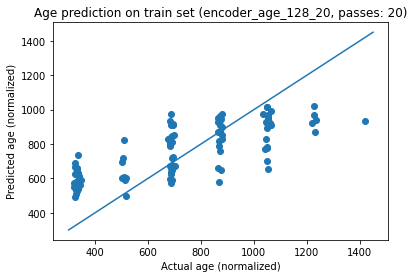

In [24]:
display_helper.show_plot(np.array(results)[:,0], 
                         np.array(results)[:,1], 
                         f"Age prediction on train set (encoder_age_128_20, passes: {n_passthroughs})", 
                         "Actual age (normalized)",
                         "Predicted age (normalized)",
                         scatter=True,
                         show=False)

plt.plot([300, 1450], [300, 1450]) # Line where predicted=actual